Student Performance Clustering Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

from scipy.cluster.hierarchy import dendrogram, linkage

Reading data

In [2]:
np.random.seed(42)

#first look at the data             
data = pd.read_csv('StudentPerformanceFactors.csv')
print(f"Data shape: {data.shape}")
data.head()

Data shape: (6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


Data Imputation

In [3]:
missing_before = data.isnull().sum()
missing_before = missing_before[missing_before > 0]
print("Features with missing values")
print(missing_before)

#checking distribution of values to choose the data imputation strategy
print(f"\n {data['Teacher_Quality'].value_counts()}")
print(f"Mode (most common): {data['Teacher_Quality'].mode()[0]}")
print(f"\n {data['Parental_Education_Level'].value_counts()}")
print(f"Mode (most common): {data['Parental_Education_Level'].mode()[0]}")
print(f"\n {data['Distance_from_Home'].value_counts()}")
print(f"Mode (most common): {data['Distance_from_Home'].mode()[0]}")

#imputation with mode
data['Teacher_Quality'].fillna('Medium', inplace=True) 
data['Parental_Education_Level'].fillna('High School', inplace=True) 
data['Distance_from_Home'].fillna('Near', inplace=True) 

Features with missing values
Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64

 Teacher_Quality
Medium    3925
High      1947
Low        657
Name: count, dtype: int64
Mode (most common): Medium

 Parental_Education_Level
High School     3223
College         1989
Postgraduate    1305
Name: count, dtype: int64
Mode (most common): High School

 Distance_from_Home
Near        3884
Moderate    1998
Far          658
Name: count, dtype: int64
Mode (most common): Near


C:\Users\kotsnova\AppData\Local\Temp\ipykernel_24704\3207947202.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Teacher_Quality'].fillna('Medium', inplace=True)
C:\Users\kotsnova\AppData\Local\Temp\ipykernel_24704\3207947202.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

Encoding categorical and binary features

In [4]:
def encode_features(df):

    df_encoded = df.copy()
    
    #features with "low, medium, high" scale
    low_medium_high_cols = [
        'Parental_Involvement', 'Access_to_Resources', 
        'Motivation_Level', 'Family_Income', 'Teacher_Quality'
    ]
    
    for col in low_medium_high_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map({'Low': 0, 'Medium': 1, 'High': 2})

    #other ordinal features
    other_ordinal = {
        'Parental_Education_Level': {'High School': 0, 'College': 1, 'Postgraduate': 2},
        'Distance_from_Home': {'Near': 0, 'Moderate': 1, 'Far': 2},
        'Peer_Influence': {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    }
    
    df_encoded.replace(other_ordinal, inplace=True)
    
    binary_cols = ['Extracurricular_Activities', 'Internet_Access', 
                   'Learning_Disabilities', 'School_Type', 'Gender']
    
    binary_map = {
        'No': 0, 'Yes': 1,
        'Public': 0, 'Private': 1,
        'Male': 0, 'Female': 1
    }
    
    for col in binary_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map(binary_map)

    return df_encoded

data_encoded = encode_features(data)
print(data_encoded.head())
print("Data types after encoding:")
print(data_encoded.dtypes)

   Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
0             23          84                     0                    2   
1             19          64                     0                    1   
2             24          98                     1                    1   
3             29          89                     0                    1   
4             19          92                     1                    1   

   Extracurricular_Activities  Sleep_Hours  Previous_Scores  Motivation_Level  \
0                           0            7               73                 0   
1                           0            8               59                 0   
2                           1            7               91                 1   
3                           1            8               98                 1   
4                           1            6               65                 1   

   Internet_Access  Tutoring_Sessions  Family_Income  Teacher_

C:\Users\kotsnova\AppData\Local\Temp\ipykernel_24704\2370292132.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded.replace(other_ordinal, inplace=True)


Checking the distribution of our data visually

array([<Axes: title={'center': 'Distribution of Exam Scores'}, xlabel='Exam Score', ylabel='Number of Students'>,
       <Axes: title={'center': 'Cumulative Distribution of Exam Scores'}, xlabel='Exam Score', ylabel='Cumulative Percentage of Students (%)'>],
      dtype=object)

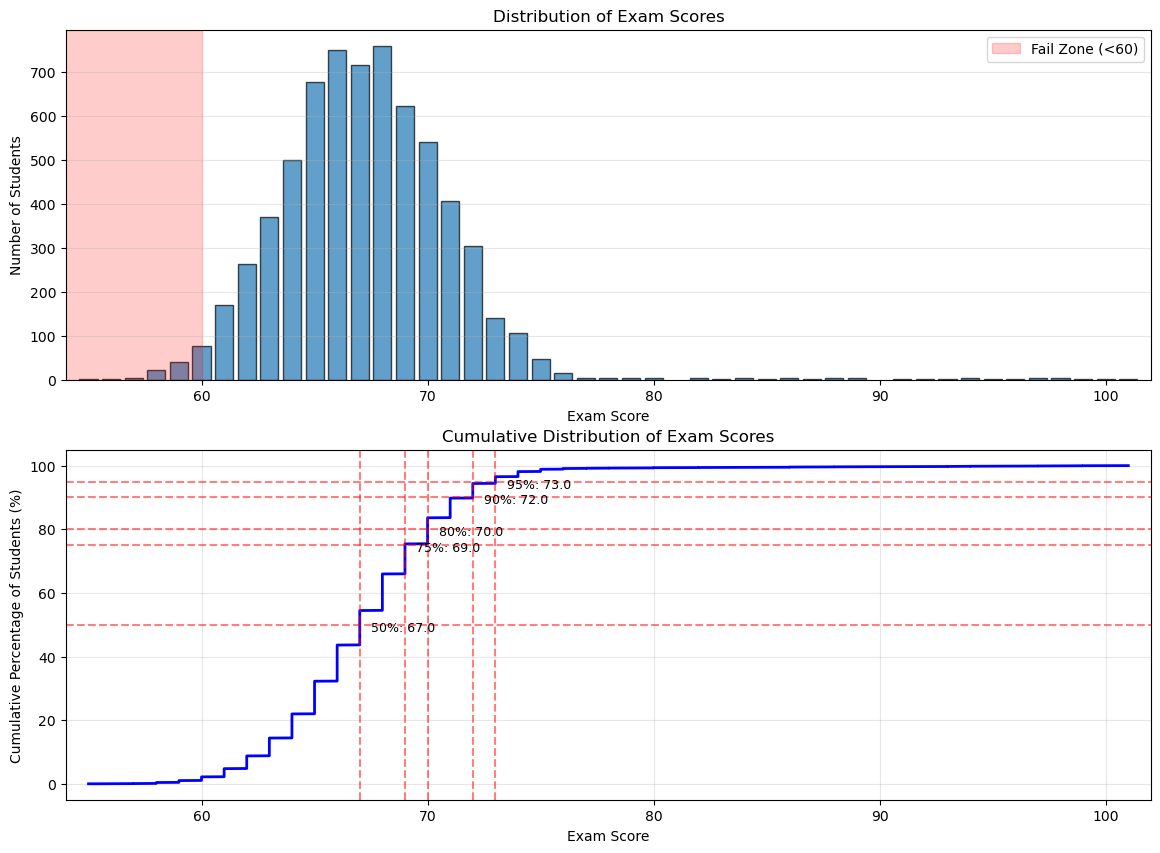

In [5]:
#visualizing a bar chart
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

score_counts = data_encoded['Exam_Score'].value_counts().sort_index()
axes[0].bar(score_counts.index, score_counts.values, width=0.8, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Number of Students')
axes[0].set_title('Distribution of Exam Scores')
axes[0].set_xlim(54, 102)
axes[0].grid(True, alpha=0.3, axis='y')

#adding a red zone for 'close to failing' scores (< 60)
axes[0].axvspan(0, 60, alpha=0.2, color='red', label='Fail Zone (<60)')
axes[0].legend()

#cumulative distribution
sorted_scores = np.sort(data_encoded['Exam_Score'])
cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores) * 100

axes[1].plot(sorted_scores, cumulative, linewidth=2, color='blue')
axes[1].set_xlabel('Exam Score')
axes[1].set_ylabel('Cumulative Percentage of Students (%)')
axes[1].set_title('Cumulative Distribution of Exam Scores')
axes[1].grid(True, alpha=0.3)

#marking key percentiles
percentiles_to_mark = [50, 75, 80, 90, 95]
for p in percentiles_to_mark:
    score_at_p = np.percentile(data_encoded['Exam_Score'], p)
    axes[1].axhline(y=p, color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(x=score_at_p, color='red', linestyle='--', alpha=0.5)
    axes[1].text(score_at_p + 0.5, p - 2, f'{p}%: {score_at_p:.1f}', fontsize=9)

axes[1].set_xlim(54, 102)
axes

The distribution appears bell-shaped and approximately normal. 
Next, we will find optimal thresholds based on the distribution.

Preparation for clustering

In [6]:
feature_columns = ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 
                   'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 
                   'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 
                   'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 
                   'Parental_Education_Level', 'Distance_from_Home', 'Gender']

X = data_encoded[feature_columns] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

#creating meaningful groups based on Standard Deviation to compare the clusters to
mean = data_encoded['Exam_Score'].mean()
std = data_encoded['Exam_Score'].std()

data_encoded['Cluster'] = clusters
data_encoded['SD_Group'] = pd.cut(
    data_encoded['Exam_Score'],
    bins=[0, mean-std, mean+std, 100],
    labels=['At-Risk', 'Average', 'High-Performing']
)

#analysis
print("Clustering Quality Metrics:")
silhouette = silhouette_score(X_scaled, clusters)
davies_bouldin = davies_bouldin_score(X_scaled, clusters)
calinski = calinski_harabasz_score(X_scaled, clusters)
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Score: {calinski:.1f}")

print("\nHow well do clusters match SD-based groups?")
for i in range(3):
    cluster_data = data_encoded[data_encoded['Cluster'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} students):")
    print(f"  Mean Exam Score: {cluster_data['Exam_Score'].mean():.1f}")
    print(f"  SD Group distribution:")
    print(cluster_data['SD_Group'].value_counts())

Clustering Quality Metrics:
Silhouette Score: 0.056
Davies-Bouldin Index: 3.760
Calinski-Harabasz Score: 334.6

How well do clusters match SD-based groups?

Cluster 0 (2381 students):
  Mean Exam Score: 67.0
  SD Group distribution:
SD_Group
Average            1802
At-Risk             377
High-Performing     201
Name: count, dtype: int64

Cluster 1 (3531 students):
  Mean Exam Score: 67.6
  SD Group distribution:
SD_Group
Average            2704
High-Performing     423
At-Risk             404
Name: count, dtype: int64

Cluster 2 (695 students):
  Mean Exam Score: 66.3
  SD Group distribution:
SD_Group
Average            475
At-Risk            170
High-Performing     50
Name: count, dtype: int64


Clustering using all features and comparing the clusters to meaningful groups

Visualizing the clusters


PCA Results:
Variance explained by PC1: 5.74%
Variance explained by PC2: 5.67%
Total variance explained: 11.42%


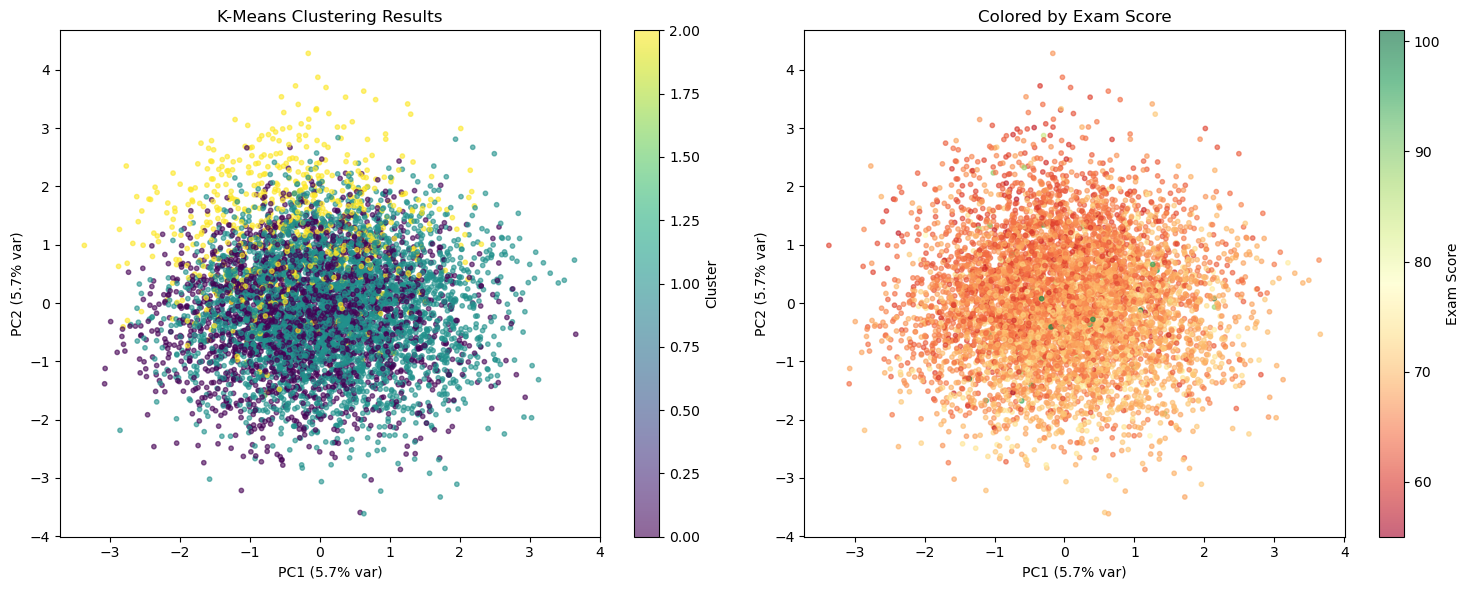

In [7]:
#PCA visualization 
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)  

print(f"\nPCA Results:")
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#image 1: clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=clusters, cmap='viridis', 
                           alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('K-Means Clustering Results')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

#image 2: exam scores
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=data_encoded['Exam_Score'], cmap='RdYlGn', 
                           alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[1].set_title('Colored by Exam Score')
plt.colorbar(scatter2, ax=axes[1], label='Exam Score')

plt.tight_layout()
plt.show()

K-means clustering failed to identify any performance-based risk groups in this dataset. The cluster mean exam scores are 67.0, 67.6, and 66.3 (a range of only 1.3 points). Each cluster contains a mix of all performance levels, and the silhouette score is 0.039, indicating extremely poor cluster structure. In short, the behavioral and demographic features in this dataset do not naturally separate students by academic performance. Risk groups must therefore be defined directly by exam scores rather than by clustering.
A detailed explanation is provided below.

Clustering using only the features with strong correlation

In [8]:
#using only the features that correlate with exam scores
important_features = ['Attendance', 'Hours_Studied']
X_important = data_encoded[important_features]

#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_important_scaled = scaler.fit_transform(X_important)

#clustering with just these 2 features
kmeans_focused = KMeans(n_clusters=3, random_state=42)
clusters_focused = kmeans_focused.fit_predict(X_important_scaled)

data_encoded['Focused_Cluster'] = clusters_focused

print("Clustering with Attendance + Hours Studied only:")
for i in range(3):
    cluster_data = data_encoded[data_encoded['Focused_Cluster'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} students):")
    print(f"  Exam Score: {cluster_data['Exam_Score'].mean():.1f} ± {cluster_data['Exam_Score'].std():.1f}")
    print(f"  Attendance: {cluster_data['Attendance'].mean():.1f}%")
    print(f"  Hours Studied: {cluster_data['Hours_Studied'].mean():.1f}")
    print(f"  SD Group distribution:")
    print(f"    At-Risk: {(cluster_data['SD_Group'] == 'At-Risk').sum()}")
    print(f"    Average: {(cluster_data['SD_Group'] == 'Average').sum()}")
    print(f"    High-Performing: {(cluster_data['SD_Group'] == 'High-Performing').sum()}")

Clustering with Attendance + Hours Studied only:

Cluster 0 (2618 students):
  Exam Score: 64.9 ± 3.2
  Attendance: 68.4%
  Hours Studied: 19.8
  SD Group distribution:
    At-Risk: 776
    Average: 1819
    High-Performing: 23

Cluster 1 (2093 students):
  Exam Score: 67.4 ± 3.3
  Attendance: 88.1%
  Hours Studied: 15.0
  SD Group distribution:
    At-Risk: 175
    Average: 1815
    High-Performing: 103

Cluster 2 (1896 students):
  Exam Score: 70.3 ± 3.1
  Attendance: 87.0%
  Hours Studied: 25.7
  SD Group distribution:
    At-Risk: 0
    Average: 1347
    High-Performing: 548


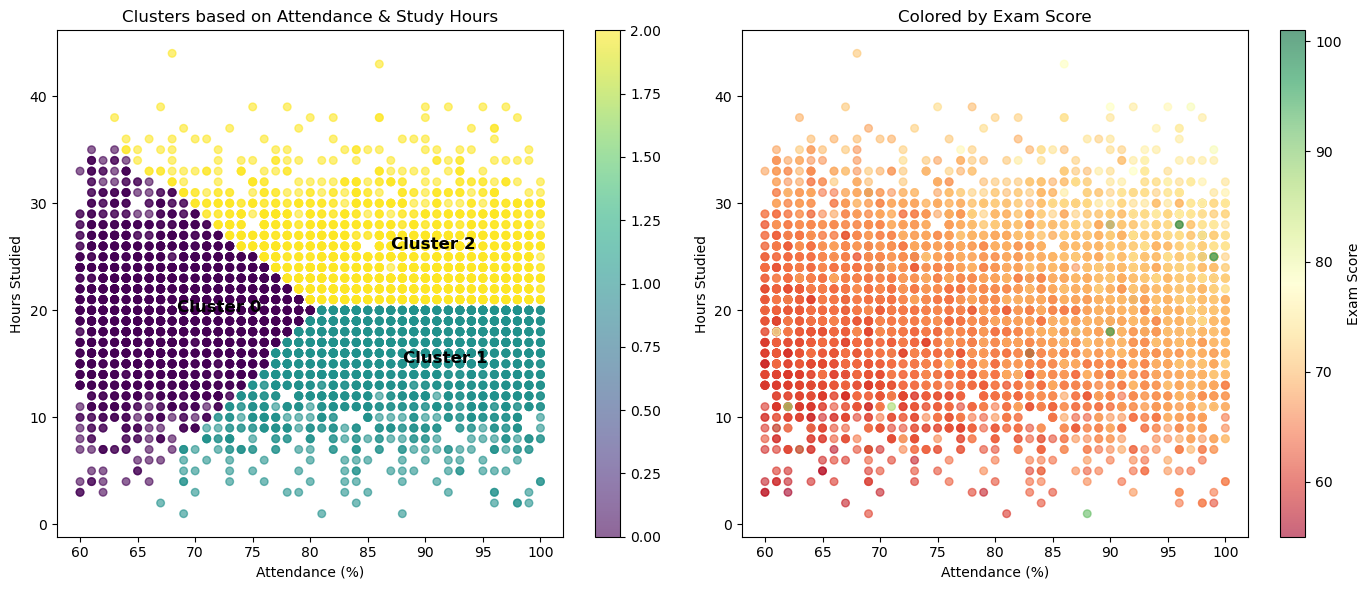

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(data_encoded['Attendance'], 
                           data_encoded['Hours_Studied'],
                           c=clusters_focused, cmap='viridis', 
                           alpha=0.6, s=30)
axes[0].set_xlabel('Attendance (%)')
axes[0].set_ylabel('Hours Studied')
axes[0].set_title('Clusters based on Attendance & Study Hours')
for i in range(3):
    cluster_data = data_encoded[data_encoded['Focused_Cluster'] == i]
    axes[0].annotate(f'Cluster {i}', 
                    xy=(cluster_data['Attendance'].mean(), 
                        cluster_data['Hours_Studied'].mean()),
                    fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(data_encoded['Attendance'], 
                           data_encoded['Hours_Studied'],
                           c=data_encoded['Exam_Score'], 
                           cmap='RdYlGn', alpha=0.6, s=30)
axes[1].set_xlabel('Attendance (%)')
axes[1].set_ylabel('Hours Studied')
axes[1].set_title('Colored by Exam Score')
plt.colorbar(scatter2, ax=axes[1], label='Exam Score')

plt.tight_layout()
plt.show()

The grid pattern from image 1 exposes that this dataset is almost certainly artificially generated. Not only that, it is poorly generated.
Cluster 1 and Cluster 2 are split exactly at 20 study hours along a perfectly straight horizontal line, and Cluster 0 is separated from the others by a flawless diagonal boundary. The data points themselves form uniform random noise scattered across the space, with no organic relationships between most of the features and the exam outcomes. These patterns strongly indicate rule-based synthetic labeling rather than genuine student behavior.
The Kaggle Data Card did not warn us about this. We did not expect the dataset to be completely natural, however, we did expect that if it was artificially generated, it would be generated 'smartly', in a way that reflects realistic relationships between features. Instead, the dataset appears to have been created by generating random values, adding noise, and then assigning labels based on simple rules. Under such conditions, the presence of 19 different features becomes meaningless, as they contain no real informational value. With features that do not reflect actual patterns and a target variable that is nearly constant, no clustering algorithm (regardless of sophistication) can extract meaningful groups, because the dataset fundamentally lacks the real-world structure that clustering and prediction methods rely on. With features that do not reflect actual patterns and a target variable that is nearly constant, no clustering algorithm (regardless of sophistication) can extract meaningful groups, because the dataset fundamentally lacks the real-world structure that clustering and prediction methods rely on.
Additional discussion on this topic is provided below.

Conclusion

Our project, INSIGHTS INTO STUDENT PERFORMANCE: Predicting Outcomes Using Machine Learning and Identifying Risk Profiles by Clustering, set out to build regression models for predicting exam scores, apply clustering to identify risk groups, and train a simple language model to generate personalized feedback for students. While we achieved technical goals such as implementing prediction models and running clustering algorithms, our most important finding was the discovery of severe structural issues within the dataset itself: issues that earlier projects relying on the same data failed to notice.

K-means clustering could not identify any meaningful performance-based groups. The average exam scores of the three clusters differ by only 1.3 points (67.0, 67.6, 66.3), and the silhouette score of 0.039 confirms an extremely weak cluster structure. The exam score variable appears to range from 1 to 100, but in reality 97% of all students fall between 60 and 70, with no students scoring below 50 and only 47 scoring above 80. Such limited variation makes both clustering and regression statistically impossible, as performance differences fall entirely within normal random noise.

Most features show virtually no correlation with exam scores, and many patterns reported in previous projects turn out to be manipulated, zoomed-in visualizations rather than meaningful relationships. For example, a correlation of 0.094 between Family Income and Exam Score is visually misrepresented as a 'trend' by one of the previously done projects. It is achieved only by restricting the y-axis to a one-point window (66.8–67.8). When the full scale is revealed, the relationship disappears.

Further analysis revealed that the dataset is not only synthetic but poorly generated synthetic data. Feature combinations form a rigid grid; clusters split along perfect geometric boundaries (e.g., exactly at 20 study hours); and the distribution resembles uniform noise rather than real student behavior. Nothing in the dataset documentation indicated this artificial construction, and while we did not expect the data to be perfectly natural, we expected synthetic data that at least resembles realistic relationships. Instead, the data appears to have been produced by generating random values, adding noise, and assigning labels based on simple thresholds. Under such conditions, the 19 features provide no actual informational value.

We did not replace the dataset because significant parts of the report and the code were completed before these issues were discovered. Switching datasets would have required redesigning the entire project under time constraints, and alternative datasets available online are much smaller and may not have led to better results.

Ultimately, even though the dataset prevented us from achieving high-quality predictions or meaningful clustering, our project reveals something equally important: how easily data can be misinterpreted, how synthetic datasets can disguise their artificial structure, and how 'patterns' can be discovered among noise, where no real patterns exist. Our analysis demonstrates why data quality assessment is essential and highlights the danger of drawing conclusions from datasets that lack genuine variance or real-world structure.

We decided to take a look at a smaller but natural data. We used Student Performance dataset from https://archive.ics.uci.edu/dataset/320/student+performance. It contains student performance in secondary education of two Portuguese schools. The data includes similar features and was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). Since these datasets are smaller in size but have the same structure, we are going to combine them to get a dataset of 1044 instances of natural data.
Differences to keep in mind:
- Final Grades are 0-20 scale (Portuguese system) instead of 0-100
- Fail threshold is <10 instead of <60

In [10]:
math_data = pd.read_csv('student-mat.csv', sep = ";")
print(f"Math dataset shape: {math_data.shape}")
math_data.head()

Math dataset shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [11]:
port_data = pd.read_csv('student-por.csv', sep = ";")
print(f"Portuguese dataset shape: {port_data.shape}")
port_data.head()

Portuguese dataset shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Combining the datasets, so we get a dataset of 1044 instances of natural data

In [12]:
math_data['subject'] = 'Math'
port_data['subject'] = 'Portuguese'

combined_data = pd.concat([math_data, port_data], ignore_index=True)

print(f"Combined dataset shape: {combined_data.shape}")
print(f"\nSubject distribution:")
print(combined_data['subject'].value_counts())
print(f"\nCombined dataset info:")
print(combined_data.head())

Combined dataset shape: (1044, 34)

Subject distribution:
subject
Portuguese    649
Math          395
Name: count, dtype: int64

Combined dataset info:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  freetime goout  Dalc  Walc  health absences  G1  G2  G3 subject  
0        3     4     1     1       3        6   5   6   6    Math  
1        3     3     1     1       3        4   5   5   6    Math  
2        3     2     2     3       3       10   7   8  10    Math  
3        2     2     1     1       5        2  15  14  15    Math  
4        3     2     

In [13]:
def encode_student_features(df):
    df_encoded = df.copy()

    #binary mapping
    binary_map = {
        'yes': 1, 'no': 0,
        'F': 0, 'M': 1,
        'U': 1, 'R': 0,
        'GT3': 1, 'LE3': 0,
        'T': 1, 'A': 0,
        'GP': 0, 'MS': 1
    }
    
    binary_cols = ['sex', 'address', 'famsize', 'Pstatus', 'school',
                   'schoolsup', 'famsup', 'paid', 'activities', 
                   'nursery', 'higher', 'internet', 'romantic']
    
    for col in binary_cols:
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].map(binary_map)
    
    if 'guardian' in df_encoded.columns:
        df_encoded['guardian'] = df_encoded['guardian'].map({
            'mother': 2, 'father': 1, 'other': 0
        })
    
    nominal_cols = ['Mjob', 'Fjob', 'reason']
    df_encoded = pd.get_dummies(df_encoded, columns=[col for col in nominal_cols if col in df_encoded.columns], 
                                 drop_first=True)
    
    df_encoded['subject'] = df_encoded['subject'].map({'Math': 0, 'Portuguese': 1})
    
    return df_encoded

combined_encoded = encode_student_features(combined_data)
print(combined_encoded.head())
print(f"\nShape after encoding: {combined_encoded.shape}")

   school  sex  age  address  famsize  Pstatus  Medu  Fedu  guardian  \
0       0    0   18        1        1        0     4     4         2   
1       0    0   17        1        1        1     1     1         1   
2       0    0   15        1        0        1     1     1         2   
3       0    0   15        1        1        1     4     2         2   
4       0    0   16        1        1        1     3     3         1   

   traveltime  ...  Mjob_other  Mjob_services  Mjob_teacher  Fjob_health  \
0           2  ...       False          False         False        False   
1           1  ...       False          False         False        False   
2           1  ...       False          False         False        False   
3           1  ...       False          False         False        False   
4           1  ...        True          False         False        False   

   Fjob_other  Fjob_services  Fjob_teacher  reason_home  reason_other  \
0       False          False         

Visualizing final grade distribution

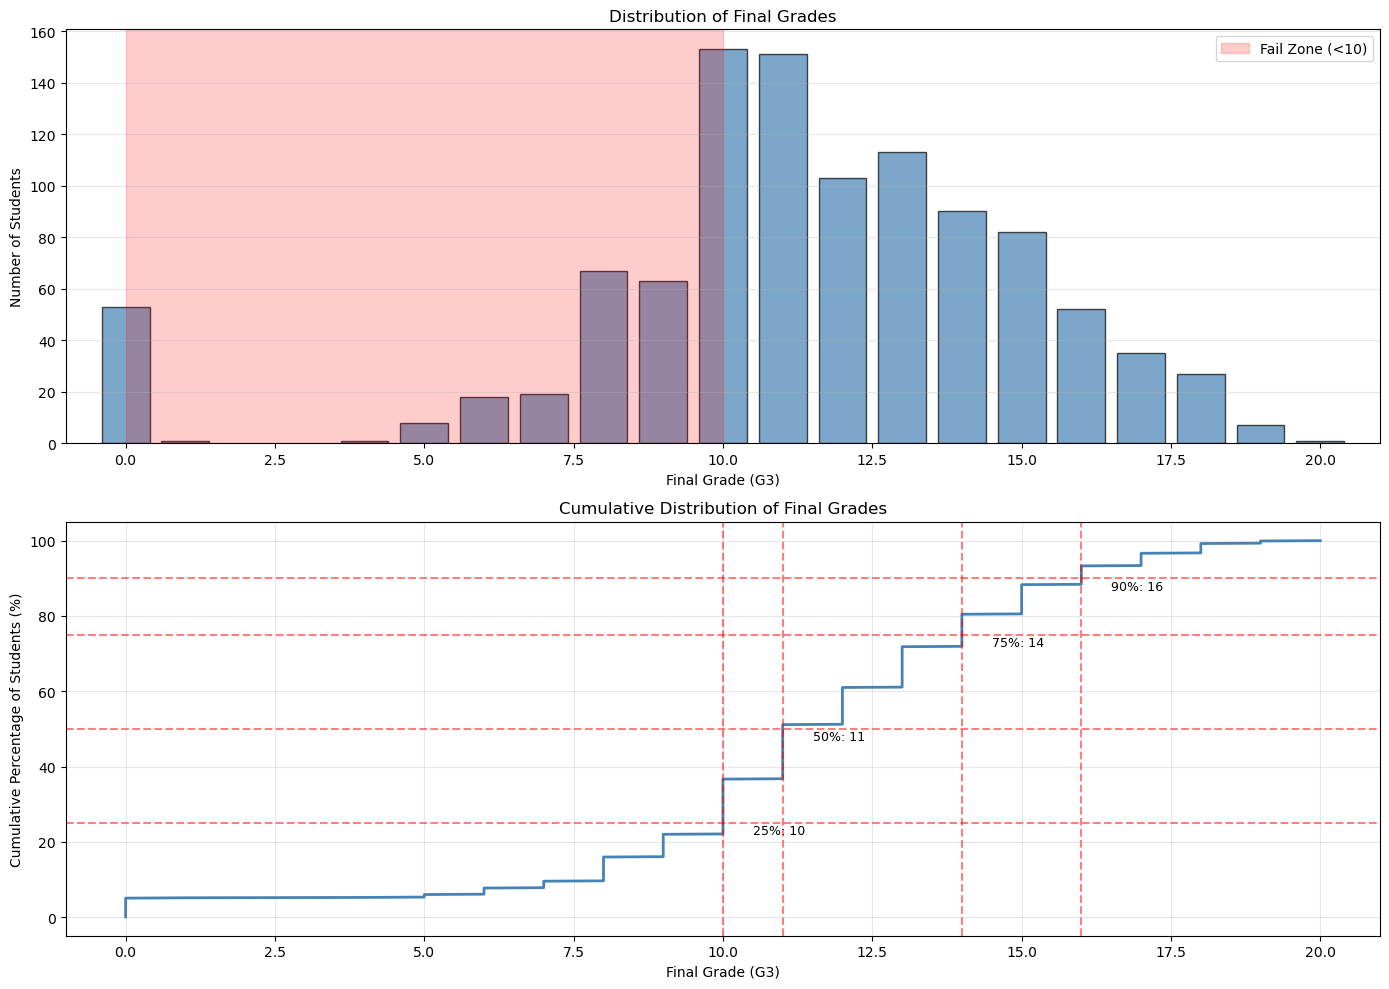

Final Grade Statistics:
Mean: 11.34
Std Dev: 3.86
Median: 11.00
Min: 0
Max: 20


In [14]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

score_counts = combined_encoded['G3'].value_counts().sort_index()
axes[0].bar(score_counts.index, score_counts.values, width=0.8, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Final Grade (G3)')
axes[0].set_ylabel('Number of Students')
axes[0].set_title('Distribution of Final Grades')
axes[0].set_xlim(-1, 21)
axes[0].grid(True, alpha=0.3, axis='y')

#adding a red zone for failing scores (< 10 in Portuguese system)
axes[0].axvspan(0, 10, alpha=0.2, color='red', label='Fail Zone (<10)')
axes[0].legend()

#cumulative distribution
sorted_scores = np.sort(combined_encoded['G3'])
cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores) * 100
axes[1].plot(sorted_scores, cumulative, linewidth=2, color='steelblue')
axes[1].set_xlabel('Final Grade (G3)')
axes[1].set_ylabel('Cumulative Percentage of Students (%)')
axes[1].set_title('Cumulative Distribution of Final Grades')
axes[1].grid(True, alpha=0.3)

#marking key percentiles
percentiles_to_mark = [25, 50, 75, 90]
for p in percentiles_to_mark:
    score_at_p = np.percentile(combined_encoded['G3'], p)
    axes[1].axhline(y=p, color='red', linestyle='--', alpha=0.5)
    axes[1].axvline(x=score_at_p, color='red', linestyle='--', alpha=0.5)
    axes[1].text(score_at_p + 0.5, p - 3, f'{p}%: {score_at_p:.0f}', fontsize=9)

axes[1].set_xlim(-1, 21)

plt.tight_layout()
plt.show()

#statistics
print("Final Grade Statistics:")
print(f"Mean: {combined_encoded['G3'].mean():.2f}")
print(f"Std Dev: {combined_encoded['G3'].std():.2f}")
print(f"Median: {combined_encoded['G3'].median():.2f}")
print(f"Min: {combined_encoded['G3'].min()}")
print(f"Max: {combined_encoded['G3'].max()}")

In [22]:
#preparation for clustering (excluding target variables G1, G2, G3)
X = combined_encoded.drop(['G1', 'G2', 'G3'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
combined_encoded['Cluster'] = clusters

print("Cluster Analysis:")
for i in range(3):
    cluster_data_new = combined_encoded[combined_encoded['Cluster'] == i]
    print(f"\nCluster {i} ({len(cluster_data_new)} students):")
    print(f"  Mean Final Grade (G3): {cluster_data_new['G3'].mean():.1f}")
    print(f"  Mean Study Time: {cluster_data_new['studytime'].mean():.2f}")
    print(f"  Mean Absences: {cluster_data_new['absences'].mean():.1f}")
    print(f"  Mean Age: {cluster_data_new['age'].mean():.1f}")
    print(f"  % with Internet: {cluster_data_new['internet'].mean()*100:.1f}%")
    print(f"  % with Higher Ed Plans: {cluster_data_new['higher'].mean()*100:.1f}%")

#clustering quality metrics
silhouette = silhouette_score(X_scaled, clusters)
davies_bouldin = davies_bouldin_score(X_scaled, clusters)
calinski = calinski_harabasz_score(X_scaled, clusters)

print(f"\nClustering Quality Metrics:")
print(f"Silhouette Score: {silhouette:.3f} (closer to 1 is better)")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)")
print(f"Calinski-Harabasz Score: {calinski:.1f} (higher is better)")

Cluster Analysis:

Cluster 0 (218 students):
  Mean Final Grade (G3): 9.2
  Mean Study Time: 1.48
  Mean Absences: 5.2
  Mean Age: 17.3
  % with Internet: 74.3%
  % with Higher Ed Plans: 71.6%

Cluster 1 (438 students):
  Mean Final Grade (G3): 11.4
  Mean Study Time: 2.10
  Mean Absences: 4.3
  Mean Age: 16.7
  % with Internet: 69.9%
  % with Higher Ed Plans: 94.3%

Cluster 2 (388 students):
  Mean Final Grade (G3): 12.4
  Mean Study Time: 2.10
  Mean Absences: 4.2
  Mean Age: 16.4
  % with Internet: 92.5%
  % with Higher Ed Plans: 99.5%

Clustering Quality Metrics:
Silhouette Score: 0.071 (closer to 1 is better)
Davies-Bouldin Index: 3.229 (lower is better)
Calinski-Harabasz Score: 69.9 (higher is better)



PCA Results:
Variance explained by PC1: 8.79%
Variance explained by PC2: 6.60%
Total variance explained: 15.39%


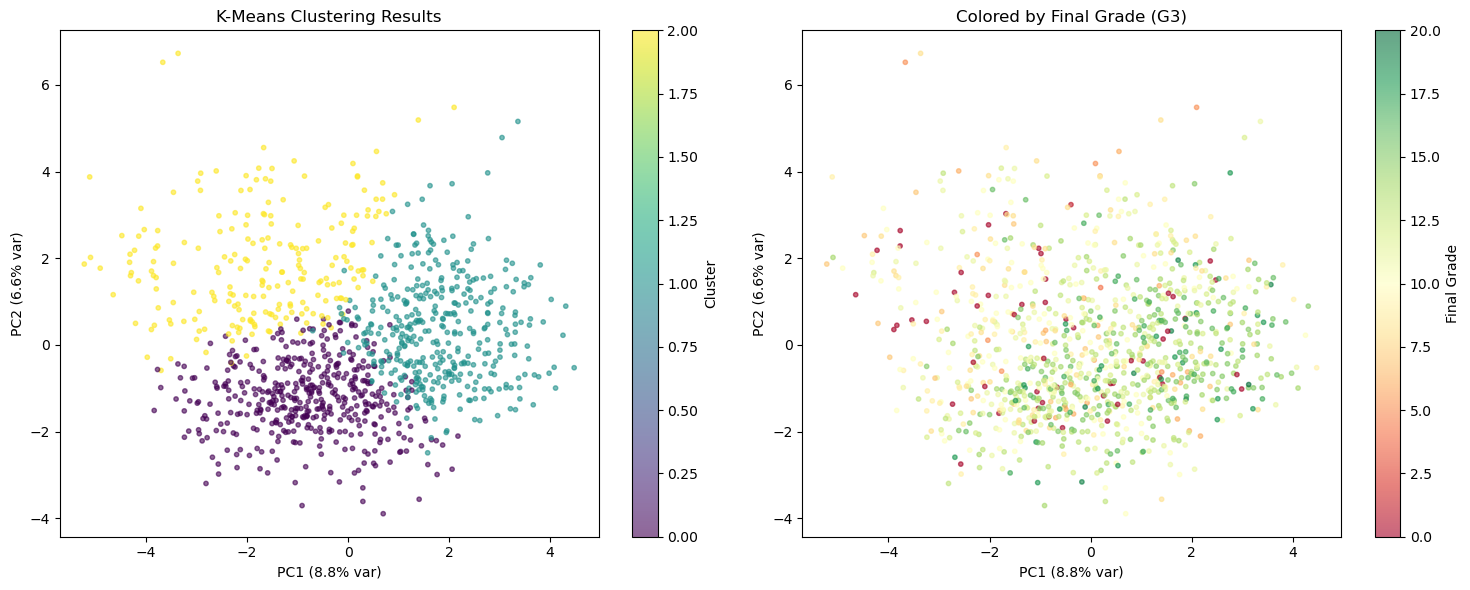

In [16]:
#PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA Results:")
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#image 1: clusters in PCA space
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=clusters, cmap='viridis',
                           alpha=0.6, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[0].set_title('K-Means Clustering Results')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

#image 2: same points colored by final grade
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                           c=combined_encoded['G3'], cmap='RdYlGn',
                           alpha=0.6, s=10)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
axes[1].set_title('Colored by Final Grade (G3)')
plt.colorbar(scatter2, ax=axes[1], label='Final Grade')

plt.tight_layout()
plt.show()

Let`s check the features that have the highest correlation with 

In [17]:
correlations = combined_encoded.corr()['G3'].abs().sort_values(ascending=False)
print("Top features correlated with Final Grade:")
print(correlations.head(10))

Top features correlated with Final Grade:
G3           1.000000
G2           0.910743
G1           0.809142
failures     0.383145
higher       0.236578
Medu         0.201472
subject      0.187166
Cluster      0.163466
studytime    0.161629
Fedu         0.159796
Name: G3, dtype: float64


We can see that the target variable in this dataset is in correlation with more features than in the artificial dataset. The author of the dataset warns us: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful. This is the reason we do not take G1 and G2 into account when clustering. 
Documentation on other features with moderate correlation:
failures: number of past class failures (numeric: n if 1<=n<3, else 4)
higher: wants to take higher education (binary: yes or no)
Medu: mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)

Next, we are going to cluster using only the features with strong correlation

In [21]:
#using only the features that correlate with exam scores
important_features = ['failures', 'higher', 'Medu']
X_important_new = combined_encoded[important_features]

#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_important_new_scaled = scaler.fit_transform(X_important_new)

#clustering with just these 2 features
kmeans_focused_new = KMeans(n_clusters=3, random_state=42)
clusters_focused_new = kmeans_focused.fit_predict(X_important_new_scaled)                                

Visualizing

KeyError: 'Focused_Cluster'

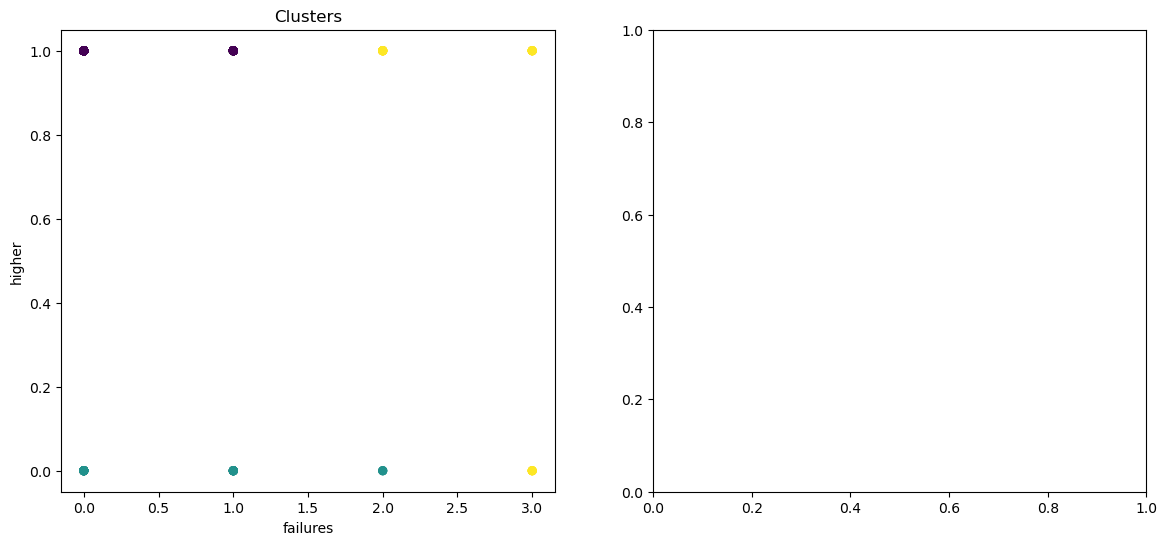